In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import os
import matplotlib.colors as clrs
from IPython.core.display import display, HTML
import anndata
from sklearn.metrics import silhouette_score
from joblib import parallel_backend
import math
import re
import pickle

/tmp/ipykernel_275455/1701034591.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
sc.settings.verbosity=0
sc.settings.set_figure_params(dpi=100)
sc.logging.print_versions()

-----
anndata     0.10.9
scanpy      1.10.3
-----
PIL                 10.4.0
asttokens           NA
bottleneck          1.3.7
cffi                1.15.1
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.6.7
decorator           5.1.1
exceptiongroup      1.2.0
executing           0.8.3
h5py                3.12.1
igraph              0.11.6
ipykernel           6.28.0
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.7
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.43.0
matplotlib          3.9.2
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numexpr             2.8.7
numpy               1.26.3
packaging           23.0
pandas              2.2.2
parso               0.8.3
patsy               0.5.6
pkg_resources       NA
platformdirs        3.10.0
plotly              6.0.1
prompt_toolkit      3.0.43
psutil     

In [3]:
colors = [(0, ("#E0E0E0")), (0.25, ("#F1F1F1")), (1,("#FD0D0D"))]
n_bins = 250 # discretizes the interpolation into bins
cmap_name = "new_list"
cm_2 = clrs.LinearSegmentedColormap.from_list(cmap_name, colors , N = n_bins)

In [4]:
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [5]:
integrated = pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/post_corrected_psclones.csv", index_col=0)
psclone_dresp = pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/psclones_dresp_predictions_rep0.csv", index_col=0)

In [6]:
gdsc=pd.read_excel("/group/iorio/Raffaele/SCDRESP_data/data/gdsc/GDSC2_fitted_dose_response.xlsx")
gdsc.rename(columns={"SANGER_MODEL_ID":"SangerModelID"},inplace=True)

In [7]:
drugs = pd.read_table("drugs_list.txt",header=None)
drugs = drugs[0].values

In [139]:
df = pd.read_csv("/group/iorio/Raffaele/SCDRESP_data/data/filtered_clustering_res.csv")
df_ext = df[["cl","CellLine"]]
df_ext= df_ext.rename(columns={"CellLine":"SangerModelID"})

In [9]:
integrated_bulk = integrated[integrated["type"] == "bulk"]
integrated_bulk = integrated_bulk[~integrated_bulk["SangerModelID"].isin(df["CellLine"])].reset_index(drop=True) # remove ccle polyclonals
integrated_pclones = integrated[integrated["type"] == "sc pseudoclones"].reset_index(drop=True)
integrated_nopolyclonals = pd.concat([integrated_pclones, integrated_bulk])

In [10]:
clines_gex = set(integrated_nopolyclonals["SangerModelID"].unique())
genes_gex = integrated_nopolyclonals.drop(columns={"SangerModelID", "tissue", "type"}).columns

training_sets_dict = {}

for dname in drugs:
    dresp_sub_df = gdsc[gdsc["DRUG_NAME"] == dname]
    clines_dresp = set(dresp_sub_df["SangerModelID"].unique())
    clines_to_keep = clines_dresp & clines_gex

    if len(clines_to_keep) < 250:
        continue

    dresp_filtered = dresp_sub_df[dresp_sub_df["SangerModelID"].isin(clines_to_keep)]
    gex_filtered = integrated_nopolyclonals[integrated_nopolyclonals["SangerModelID"].isin(clines_to_keep)]
    
    df = gex_filtered.merge(dresp_filtered, on="SangerModelID", how="left")
    
    # Select lineage with at least 10 cell lines
    octype_counts = df["tissue"].value_counts()
    octype_counts = octype_counts[octype_counts > 10].index
    df = df[df["tissue"].isin(octype_counts)]

    # retain HVF
    X = df.loc[:, df.columns.isin(genes_gex)]
    cv = np.std(X, axis=0)/np.mean(X, axis=0)
    threshold = np.percentile(cv,90)
    hvf = cv[cv > threshold].index
    X_hvf = X.loc[:, X.columns.isin(hvf)]

    # Save filtered dataset
    training_sets_dict[dname] = {
        "OBS": df["SangerModelID"].reset_index(drop=True),
        "X": X_hvf.reset_index(drop=True),  # Retaining only HVF genes
        "Y": df["LN_IC50"].reset_index(drop=True),
        "Metadata": df[["tissue", "CELL_LINE_NAME", "PATHWAY_NAME", "COSMIC_ID"]].reset_index(drop=True)
    }


In [39]:
with open("/group/iorio/Raffaele/SCDRESP_data/data/training_sets_dict_nopoly.pkl", "wb") as f:
    pickle.dump(training_sets_dict, f)

In [28]:
data_A = integrated[integrated["type"] == "bulk"]
data_B = data_A[data_A["SangerModelID"].isin(df["CellLine"])].reset_index(drop=True)
data_B

,A1BG,A1CF,A2M,A2ML1,A4GALT,AAAS,AACS,AADAC,AADACL3,AADAT,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,tissue,type,SangerModelID
0,4.242017,0.176777,4.123320,0.091677,3.710965,4.895678,4.058556,0.441785,0.110086,2.931329,...,1.170656,1.809427,3.429990,0.094883,3.669829,7.385574,3.897599,CNS/Brain,bulk,SIDM01155
1,2.601575,0.118530,0.146090,0.105761,2.000915,4.764540,4.460741,3.570887,0.110086,0.867847,...,0.555495,1.347984,3.427429,0.030314,1.719090,5.883681,2.680079,Pancreas,bulk,SIDM00950
2,4.495173,0.094436,3.052296,0.091677,3.815957,5.187138,3.676964,0.178121,0.110086,2.158299,...,1.170656,1.673946,3.249893,0.017018,3.228591,7.306290,3.653754,CNS/Brain,bulk,SIDM00131
3,4.260644,0.106542,0.102302,0.160737,2.575710,5.030168,3.904407,0.103105,0.110086,1.408836,...,1.221472,2.367483,2.853933,1.411873,3.056025,6.254304,2.749860,Lung,bulk,SIDM00306
4,5.100565,0.094436,6.074669,0.091677,1.174376,5.138948,4.035141,0.271961,0.110086,3.081769,...,1.034931,1.826045,3.355367,0.226825,2.747953,6.381592,3.540266,Skin,bulk,SIDM00663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,4.286508,0.082209,0.072389,0.147192,4.301567,5.607874,4.889057,0.141144,0.110086,1.840868,...,1.196294,1.945108,3.009850,2.755112,3.041237,4.844197,2.490822,Ovary/Fallopian Tube,bulk,SIDM00481
72,4.730144,0.094436,0.230033,3.779812,5.593532,5.046057,4.262563,0.790166,0.110086,0.839123,...,1.487749,3.106772,3.580298,1.334383,2.205475,6.290592,2.987051,Head and Neck,bulk,SIDM00078
73,4.159548,0.082209,0.188644,0.226583,2.821183,5.570428,4.144062,0.115906,0.110086,0.210403,...,1.006137,1.948917,3.351746,2.340489,2.295949,3.583906,3.085568,Breast,bulk,SIDM00097
74,4.882293,0.153808,0.309555,1.738046,5.644555,4.696992,4.356706,0.103105,0.110086,1.770751,...,1.252323,1.941288,3.550373,2.721986,2.860469,4.706754,3.576263,Breast,bulk,SIDM00881


In [29]:
X_test_unseen = data_B.iloc[:,:-3].fillna(0).to_numpy()
X_test_unseen

array([[4.24201741, 0.1767766 , 4.12331962, ..., 3.66982911, 7.38557385,
        3.8975988 ],
       [2.6015755 , 0.11852998, 0.14609001, ..., 1.71908965, 5.8836807 ,
        2.68007885],
       [4.4951734 , 0.0944356 , 3.05229586, ..., 3.22859091, 7.30629041,
        3.65375406],
       ...,
       [4.15954758, 0.0822089 , 0.18864436, ..., 2.29594909, 3.58390628,
        3.08556818],
       [4.88229256, 0.1538082 , 0.30955525, ..., 2.86046877, 4.70675393,
        3.57626313],
       [4.55752027, 0.14601697, 4.31263945, ..., 2.50235126, 5.78209706,
        3.19011063]])

In [14]:
path_to_pkl = "/group/iorio/Raffaele/SCDRESP_data/data/results/elnet_nopoly_rep0/"

# Dictionary to store loaded models with drug names as keys
models_dict = {}

pattern = r"elastic_net_model_(.+)\.pkl"

for file in os.listdir(path_to_pkl):
    if file.endswith(".pkl"): 
        match = re.match(pattern, file)  
        if match:
            drug_name = match.group(1)  
            file_path = os.path.join(path_to_pkl, file)
            
            with open(file_path, "rb") as f:
                models_dict[drug_name] = pickle.load(f)

In [15]:
features_X_test_unseen = integrated_nopolyclonals.drop(columns={"SangerModelID", "tissue","type"}).columns

In [16]:
X_test_unseen = pd.DataFrame(X_test_unseen, columns=features_X_test_unseen)

In [17]:
X_test_unseen

,A1BG,A1CF,A2M,A2ML1,A4GALT,AAAS,AACS,AADAC,AADACL3,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,4.242017,0.176777,4.123320,0.091677,3.710965,4.895678,4.058556,0.441785,0.110086,2.931329,...,4.475800,4.531199,6.894066,1.170656,1.809427,3.429990,0.094883,3.669829,7.385574,3.897599
1,2.601575,0.118530,0.146090,0.105761,2.000915,4.764540,4.460741,3.570887,0.110086,0.867847,...,4.193466,4.534006,6.480915,0.555495,1.347984,3.427429,0.030314,1.719090,5.883681,2.680079
2,4.495173,0.094436,3.052296,0.091677,3.815957,5.187138,3.676964,0.178121,0.110086,2.158299,...,4.059704,5.024565,7.460854,1.170656,1.673946,3.249893,0.017018,3.228591,7.306290,3.653754
3,4.260644,0.106542,0.102302,0.160737,2.575710,5.030168,3.904407,0.103105,0.110086,1.408836,...,3.710509,3.086940,5.512084,1.221472,2.367483,2.853933,1.411873,3.056025,6.254304,2.749860
4,5.100565,0.094436,6.074669,0.091677,1.174376,5.138948,4.035141,0.271961,0.110086,3.081769,...,4.301190,4.582051,5.919942,1.034931,1.826045,3.355367,0.226825,2.747953,6.381592,3.540266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,4.286508,0.082209,0.072389,0.147192,4.301567,5.607874,4.889057,0.141144,0.110086,1.840868,...,3.998204,4.343139,7.071061,1.196294,1.945108,3.009850,2.755112,3.041237,4.844197,2.490822
72,4.730144,0.094436,0.230033,3.779812,5.593532,5.046057,4.262563,0.790166,0.110086,0.839123,...,2.825524,3.394532,4.795211,1.487749,3.106772,3.580298,1.334383,2.205475,6.290592,2.987051
73,4.159548,0.082209,0.188644,0.226583,2.821183,5.570428,4.144062,0.115906,0.110086,0.210403,...,4.575750,3.876381,7.541362,1.006137,1.948917,3.351746,2.340489,2.295949,3.583906,3.085568
74,4.882293,0.153808,0.309555,1.738046,5.644555,4.696992,4.356706,0.103105,0.110086,1.770751,...,3.901396,4.137586,7.558624,1.252323,1.941288,3.550373,2.721986,2.860469,4.706754,3.576263


In [18]:
predictions_dict = {}
for drug_name, model in models_dict.items():
    print(f"drug: {drug_name}")
    elnet_fit = model["model"]
    df = pd.DataFrame({"mean":pd.Series(model["scaler_mean"]).values,"scale":pd.Series(model["scaler_scale"]).values}, index=model["pre_filter_features"])
    print(df.index)
    df = df[df.index.isin(model["post_filter_features"])]
    X_test_filtered = X_test_unseen.reindex(columns=df.index)
    print(X_test_filtered.columns) # genes
    print(df["mean"])
    print(df["scale"])
    X_test_scaled = (X_test_filtered - df["mean"])/df["scale"]
    #print(X_test_scaled.index)
    predictions = elnet_fit.predict(X_test_scaled)
    # Store predictions
    predictions_dict[drug_name] = predictions

drug: JAK_8517
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZDHHC22', 'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208',
       'ZNF536', 'ZNF560', 'ZNF98'],
      dtype='object', length=1653)
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZDHHC22', 'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208',
       'ZNF536', 'ZNF560', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.327537
A2M       0.798662
A2ML1     0.425998
AADAC     0.629930
ABCA6     0.395048
            ...   
ZMAT4     0.508048
ZNF208    0.418426
ZNF536    0.346264
ZNF560    0.377769
ZNF98     0.410227
Name: mean, Length: 1653, dtype: float64
A1CF      0.642724
A2M       1.550147
A2ML1     0.808208
AADAC     1.070078
ABCA6     0.639765
            ...   
ZMAT4     0.875277
ZNF208    0.698906
ZNF536    0.596884
ZNF560    0.657728
ZNF98     0.664951
Name: scale, Len

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: Motesanib
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCB5', 'ABCC8', 'ABCC9', 'ABI3',
       'ACAN', 'ACTC1',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCB5', 'ABCC8', 'ABCC9', 'ABI3',
       'ACAN', 'ACTC1',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.312976
A2M       0.861752
A2ML1     0.416947
AADAC     0.607176
ABCB5     0.341708
            ...   
ZNF208    0.433596
ZNF536    0.384223
ZNF560    0.393694
ZNF676    0.320972
ZNF98     0.408237
Name: mean, Length: 1653, dtype: float64
A1CF      0.635441
A2M       1.739517
A2ML1     0.761742
AADAC     1.029655
ABCB5     0.793660
            ...   
ZNF208    0.750812
ZNF536    0.692624
ZNF560    0.677547
ZNF676    0.525512
ZNF98     0.677078
Name: scale, Length: 

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

A1CF      0.635441
A2M       1.739517
A2ML1     0.761742
AADAC     1.029655
ABCB5     0.793660
            ...   
ZNF208    0.750812
ZNF536    0.692624
ZNF560    0.677547
ZNF676    0.525512
ZNF98     0.677078
Name: scale, Length: 1653, dtype: float64
drug: 776928
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.321315
A2M       0.802949
A2ML1     0.426584
AADAC     0.634274
ABCA6     0.396180
            ...   
ZNF208    0.419333
ZNF536    0.347640
ZNF560    0.379418
ZNF676    0.314405
ZNF98     0.410219
Name: mean, Length:

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: Obatoclax Mesylate
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCB5', 'ABCC8', 'ABCC9', 'ABI3',
       'ACAN', 'ACTC1',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCB5', 'ABCC8', 'ABCC9', 'ABI3',
       'ACAN', 'ACTC1',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.326935
A2M       0.826818
A2ML1     0.431597
AADAC     0.627215
ABCB5     0.306664
            ...   
ZNF208    0.417715
ZNF536    0.360246
ZNF560    0.381860
ZNF676    0.317370
ZNF98     0.398159
Name: mean, Length: 1653, dtype: float64
A1CF      0.663549
A2M       1.602782
A2ML1     0.811149
AADAC     1.064497
ABCB5     0.688110
            ...   
ZNF208    0.708323
ZNF536    0.628732
ZNF560    0.672754
ZNF676    0.522083
ZNF98     0.653980
Name: scale,

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

A1CF      0.635369
A2M       1.733143
A2ML1     0.787775
AADAC     1.029740
ABCB5     0.790478
            ...   
ZNF208    0.743920
ZNF536    0.690042
ZNF560    0.675154
ZNF676    0.523669
ZNF98     0.673143
Name: scale, Length: 1653, dtype: float64
drug: UNC0638
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC8', 'ABCC9',
       'ABHD12B', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC8', 'ABCC9',
       'ABHD12B', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.308305
A2M       0.781892
A2ML1     0.424951
AADAC     0.634374
ABCA6     0.380323
            ...   
ZNF208    0.419043
ZNF536    0.362539
ZNF560    0.384144
ZNF676    0.320951
ZNF98     0.411945
Name: mean, Leng

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: Epirubicin
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCB5', 'ABCC8', 'ABCC9', 'ABI3',
       'ACAN', 'ACTC1',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCB5', 'ABCC8', 'ABCC9', 'ABI3',
       'ACAN', 'ACTC1',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.312036
A2M       0.850578
A2ML1     0.416871
AADAC     0.602044
ABCB5     0.339137
            ...   
ZNF208    0.430439
ZNF536    0.382746
ZNF560    0.386737
ZNF676    0.319438
ZNF98     0.403822
Name: mean, Length: 1653, dtype: float64
A1CF      0.633951
A2M       1.731914
A2ML1     0.770924
AADAC     1.024517
ABCB5     0.789937
            ...   
ZNF208    0.747550
ZNF536    0.692991
ZNF560    0.666319
ZNF676    0.523420
ZNF98     0.672912
Name: scale, Length:

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

A1CF      0.638807
A2M       1.517857
A2ML1     0.831244
AADAC     1.084049
ABCA6     0.634302
            ...   
ZNF208    0.714677
ZNF536    0.585803
ZNF560    0.673264
ZNF676    0.532663
ZNF98     0.671023
Name: scale, Length: 1653, dtype: float64
drug: BDF00022089a
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.320964
A2M       0.801829
A2ML1     0.426060
AADAC     0.633427
ABCA6     0.395709
            ...   
ZNF208    0.418815
ZNF536    0.347360
ZNF560    0.378985
ZNF676    0.314071
ZNF98     0.409706
Name: mean, L

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: BDILV000379a
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.320964
A2M       0.801829
A2ML1     0.426060
AADAC     0.633427
ABCA6     0.395709
            ...   
ZNF208    0.418815
ZNF536    0.347360
ZNF560    0.378985
ZNF676    0.314071
ZNF98     0.409706
Name: mean, Length: 1653, dtype: float64
A1CF      0.618922
A2M       1.553266
A2ML1     0.809959
AADAC     1.071736
ABCA6     0.641202
            ...   
ZNF208    0.700275
ZNF536    0.598138
ZNF560    0.659107
ZNF676    0.507616
ZNF98     0.665432
Name: scale, L

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

A1CF      0.633951
A2M       1.731914
A2ML1     0.770924
AADAC     1.024517
ABCB5     0.789937
            ...   
ZNF208    0.747550
ZNF536    0.692991
ZNF560    0.666319
ZNF676    0.523420
ZNF98     0.672912
Name: scale, Length: 1653, dtype: float64
drug: AZD8055
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC8', 'ABCC9',
       'ABHD12B', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC8', 'ABCC9',
       'ABHD12B', 'ABI3',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.315995
A2M       0.794152
A2ML1     0.434471
AADAC     0.639409
ABCA6     0.376869
            ...   
ZNF208    0.414113
ZNF536    0.358839
ZNF560    0.385140
ZNF676    0.317888
ZNF98     0.412897
Name: mean, Leng

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: LMB_AB3
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.320964
A2M       0.801829
A2ML1     0.426060
AADAC     0.633427
ABCA6     0.395709
            ...   
ZNF208    0.418815
ZNF536    0.347360
ZNF560    0.378985
ZNF676    0.314071
ZNF98     0.409706
Name: mean, Length: 1653, dtype: float64
A1CF      0.618922
A2M       1.553266
A2ML1     0.809959
AADAC     1.071736
ABCA6     0.641202
            ...   
ZNF208    0.700275
ZNF536    0.598138
ZNF560    0.659107
ZNF676    0.507616
ZNF98     0.665432
Name: scale, Length

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: Entospletinib
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA8', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZDHHC22', 'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208',
       'ZNF536', 'ZNF560', 'ZNF98'],
      dtype='object', length=1653)
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA8', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZDHHC22', 'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208',
       'ZNF536', 'ZNF560', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.310575
A2M       0.836734
A2ML1     0.416535
AADAC     0.607433
ABCA8     0.422510
            ...   
ZMAT4     0.538921
ZNF208    0.429362
ZNF536    0.375024
ZNF560    0.388326
ZNF98     0.411354
Name: mean, Length: 1653, dtype: float64
A1CF      0.610051
A2M       1.702598
A2ML1     0.783292
AADAC     1.031022
ABCA8     0.686714
            ...   
ZMAT4     0.929050
ZNF208    0.740770
ZNF536    0.675150
ZNF560    0.662498
ZNF98     0.681658
Name: scale

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: SGC0946
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCB5', 'ABCC8', 'ABCC9', 'ABI3',
       'ACAN', 'ACTC1',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCB5', 'ABCC8', 'ABCC9', 'ABI3',
       'ACAN', 'ACTC1',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.311948
A2M       0.851997
A2ML1     0.424869
AADAC     0.600935
ABCB5     0.340099
            ...   
ZNF208    0.430809
ZNF536    0.382162
ZNF560    0.383373
ZNF676    0.314857
ZNF98     0.396190
Name: mean, Length: 1653, dtype: float64
A1CF      0.635640
A2M       1.737900
A2ML1     0.790616
AADAC     1.027224
ABCB5     0.793914
            ...   
ZNF208    0.751046
ZNF536    0.692933
ZNF560    0.660585
ZNF676    0.515982
ZNF98     0.658343
Name: scale, Length: 16

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: Ulixertinib
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA8', 'ABCB5', 'ABCC8', 'ABCC9',
       'ABI3', 'ACAN',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA8', 'ABCB5', 'ABCC8', 'ABCC9',
       'ABI3', 'ACAN',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.311413
A2M       0.812093
A2ML1     0.422872
AADAC     0.612064
ABCA8     0.409878
            ...   
ZNF208    0.432960
ZNF536    0.370191
ZNF560    0.395479
ZNF676    0.324467
ZNF98     0.414786
Name: mean, Length: 1653, dtype: float64
A1CF      0.631533
A2M       1.625557
A2ML1     0.788394
AADAC     1.040358
ABCA8     0.682021
            ...   
ZNF208    0.743428
ZNF536    0.657558
ZNF560    0.686401
ZNF676    0.541509
ZNF98     0.697701
Name: scale, Length

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCB5', 'ABCC8', 'ABCC9', 'ABI3',
       'ACAN', 'ACTC1',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.312131
A2M       0.853453
A2ML1     0.416033
AADAC     0.599260
ABCB5     0.337601
            ...   
ZNF208    0.428572
ZNF536    0.382894
ZNF560    0.388807
ZNF676    0.317991
ZNF98     0.403897
Name: mean, Length: 1653, dtype: float64
A1CF      0.632659
A2M       1.728294
A2ML1     0.769563
AADAC     1.017083
ABCB5     0.787081
            ...   
ZNF208    0.745056
ZNF536    0.692300
ZNF560    0.672407
ZNF676    0.521661
ZNF98     0.671973
Name: scale, Length: 1653, dtype: float64
drug: XAV939
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA8', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='ob

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

drug: BEN
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
Index(['A1CF', 'A2M', 'A2ML1', 'AADAC', 'ABCA6', 'ABCB5', 'ABCC9', 'ABHD12B',
       'ABI3', 'ACAN',
       ...
       'ZFP42', 'ZFP57', 'ZFR2', 'ZIC3', 'ZMAT4', 'ZNF208', 'ZNF536', 'ZNF560',
       'ZNF676', 'ZNF98'],
      dtype='object', length=1653)
A1CF      0.320964
A2M       0.801829
A2ML1     0.426060
AADAC     0.633427
ABCA6     0.395709
            ...   
ZNF208    0.418815
ZNF536    0.347360
ZNF560    0.378985
ZNF676    0.314071
ZNF98     0.409706
Name: mean, Length: 1653, dtype: float64
A1CF      0.618922
A2M       1.553266
A2ML1     0.809959
AADAC     1.071736
ABCA6     0.641202
            ...   
ZNF208    0.700275
ZNF536    0.598138
ZNF560    0.659107
ZNF676    0.507616
ZNF98     0.665432
Name: scale, Length: 16

/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted without feature names
  warnings.warn(
/home/raffaele.iannuzzi/miniconda3/envs/scanpy_backup_v2/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNetCV was fitted

In [23]:
df_pred = pd.DataFrame(predictions_dict)
df_pred["SangerModelID"] = data_B["SangerModelID"].values
df_pred["tissue"] = data_B["tissue"].values

In [183]:
df_pred_test = df_pred

In [184]:
for k in training_sets_dict.keys():
    df_pred_test[k] = df_pred_test.groupby("tissue")[k].transform(
    lambda x: (x - x.mean()) / x.std()
)

In [65]:
clines_gex = set(data_B["SangerModelID"].unique())
genes_gex = data_B.drop(columns={"SangerModelID", "tissue", "type"}).columns

training_sets_dict = {}

for dname in drugs:
    dresp_sub_df = gdsc[gdsc["DRUG_NAME"] == dname]
    clines_dresp = set(dresp_sub_df["SangerModelID"].unique())
    clines_to_keep = clines_dresp & clines_gex

    dresp_filtered = dresp_sub_df[dresp_sub_df["SangerModelID"].isin(clines_to_keep)]
    gex_filtered = data_B[data_B["SangerModelID"].isin(clines_to_keep)]
    
    df = data_B.merge(dresp_filtered, on="SangerModelID", how="left")
    
    if len(df) > 76:
        df = df.groupby("SangerModelID", as_index=False).mean("LN_IC50")
        
    
    training_sets_dict[dname] = {
        "OBS": df["SangerModelID"].reset_index(drop=True),
        "Y": df["LN_IC50"].reset_index(drop=True),
    }

In [66]:
for i, k in enumerate(training_sets_dict.keys()):
    print(f"{k}: {len(training_sets_dict[k]['Y'])}")

Elephantin: 76
GSK2606414: 76
MG-132: 76
UMI-77: 76
N25720-51-A1: 76
Bleomycin (50 uM): 76
EHT-1864: 76
Wnt-C59: 76
AGK2: 76
Camptothecin: 76
PAK_5339: 76
AT13148: 76
CPI-637: 76
Bromosporine: 76
PD173074: 76
MK-1775: 76
PD0325901: 76
Gallibiscoquinazole: 76
Bosutinib: 76
BPD-00008900: 76
Tanespimycin: 76
Talazoparib: 76
Daporinad: 76
VE821: 76
LMB_AB2: 76
SCH772984: 76
TAF1_5496: 76
Motesanib: 76
Axitinib: 76
Olaparib: 76
BMS-345541: 76
Acetalax: 76
POMHEX: 76
765771: 76
CT7033-2: 76
BMS-536924: 76
alpha-lipoic acid: 76
LGK974: 76
PRT062607: 76
IGF1R_3801: 76
Sepantronium bromide: 76
Podophyllotoxin bromide: 76
BDILV000379a: 76
Osimertinib: 76
P22077: 76
Temozolomide: 76
ML323: 76
Romidepsin: 76
GSK2578215A: 76
Pevonedistat: 76
Lenalidomide: 76
Teniposide: 76
Vinorelbine: 76
VTP-B: 76
glutathione: 76
JQ1: 76
Obatoclax Mesylate: 76
N30652-18-1: 76
Cyclophosphamide: 76
EPZ5676: 76
YK-4-279: 76
Methotrexate: 76
AZD4547: 76
GSK343: 76
Palbociclib: 76
OF-1: 76
Telomerase Inhibitor IX: 76
B

In [68]:
df_exp = pd.DataFrame({k: training_sets_dict[k]["Y"] for k in training_sets_dict.keys()})

In [141]:
from scipy.stats import pearsonr
import pandas as pd

correlation_results = []

for i in range(len(df_pred)):
    # Combine observed and predicted values and drop NaNs
    temp_df = pd.DataFrame({
        "exp": df_exp.iloc[i,],
        "pred": df_pred.iloc[i,:-2]
    }).dropna()

    if len(temp_df) > 1:
        r, p = pearsonr(temp_df["exp"], temp_df["pred"])
        correlation_results.append({
            "Pearson_r": r,
            "p_value": p,
            "n_samples": len(temp_df)
        })
    else:
        correlation_results.append({
            "Pearson_r": None,
            "p_value": None,
            "n_samples": len(temp_df)
        })

# Convert to DataFrame
correlation_df = pd.DataFrame(correlation_results)
correlation_df["SangerModelID"] = df_pred["SangerModelID"]
correlation_df["tissue"] = df_pred["tissue"]
correlation_df = pd.merge(correlation_df, df_ext, on="SangerModelID", how="left")

In [210]:
correlation_df["group"] = np.where(correlation_df["cl"].isin([2]), 0, 1)
correlation_df

,Pearson_r,p_value,n_samples,SangerModelID,tissue,cl,group
0,0.941642,9.673228e-129,270,SIDM01155,CNS/Brain,2,0
1,0.959562,5.192461e-149,269,SIDM00950,Pancreas,2,0
2,0.751024,1.967917e-02,9,SIDM00131,CNS/Brain,3,1
3,0.883045,2.278921e-90,271,SIDM00306,Lung,2,0
4,0.929171,3.230998e-73,167,SIDM00663,Skin,2,0
...,...,...,...,...,...,...,...
71,0.942424,1.671063e-129,270,SIDM00481,Ovary/Fallopian Tube,4,1
72,0.824487,1.187984e-42,167,SIDM00078,Head and Neck,5,1
73,0.944030,4.212826e-131,270,SIDM00097,Breast,2,0
74,0.875662,1.057164e-86,270,SIDM00881,Breast,2,0


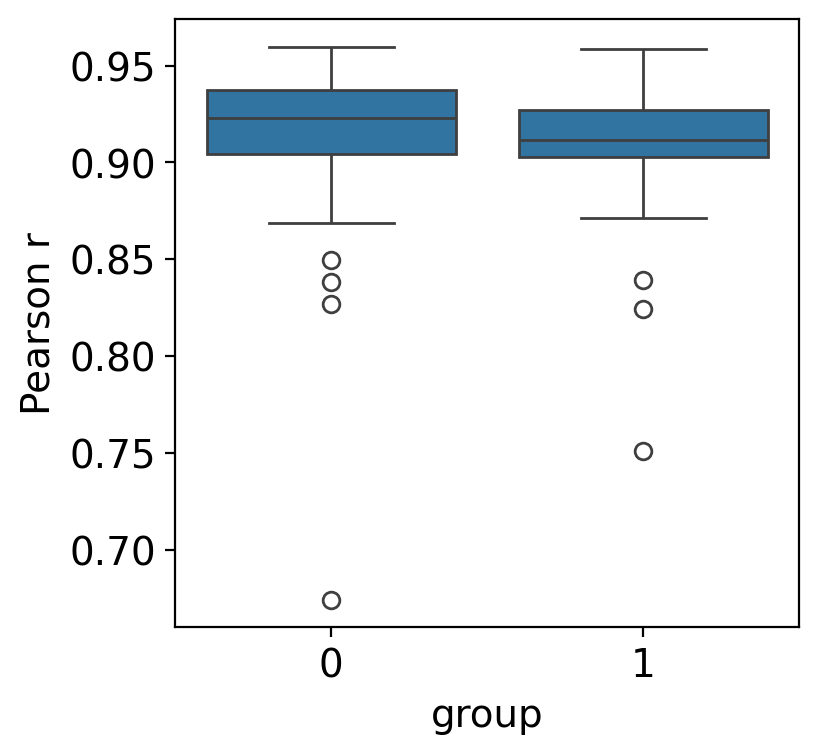

In [211]:
sns.boxplot(correlation_df, x="group", y="Pearson_r")
plt.title("")
plt.ylabel("Pearson r")
plt.grid(False)

In [214]:
from scipy import stats
t_stat, p_value = stats.ttest_ind(correlation_df[correlation_df["group"]==0]["Pearson_r"], 
                                  correlation_df[correlation_df["group"]==1]["Pearson_r"])
print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3e}")

T-statistic: 0.592, p-value: 5.555e-01


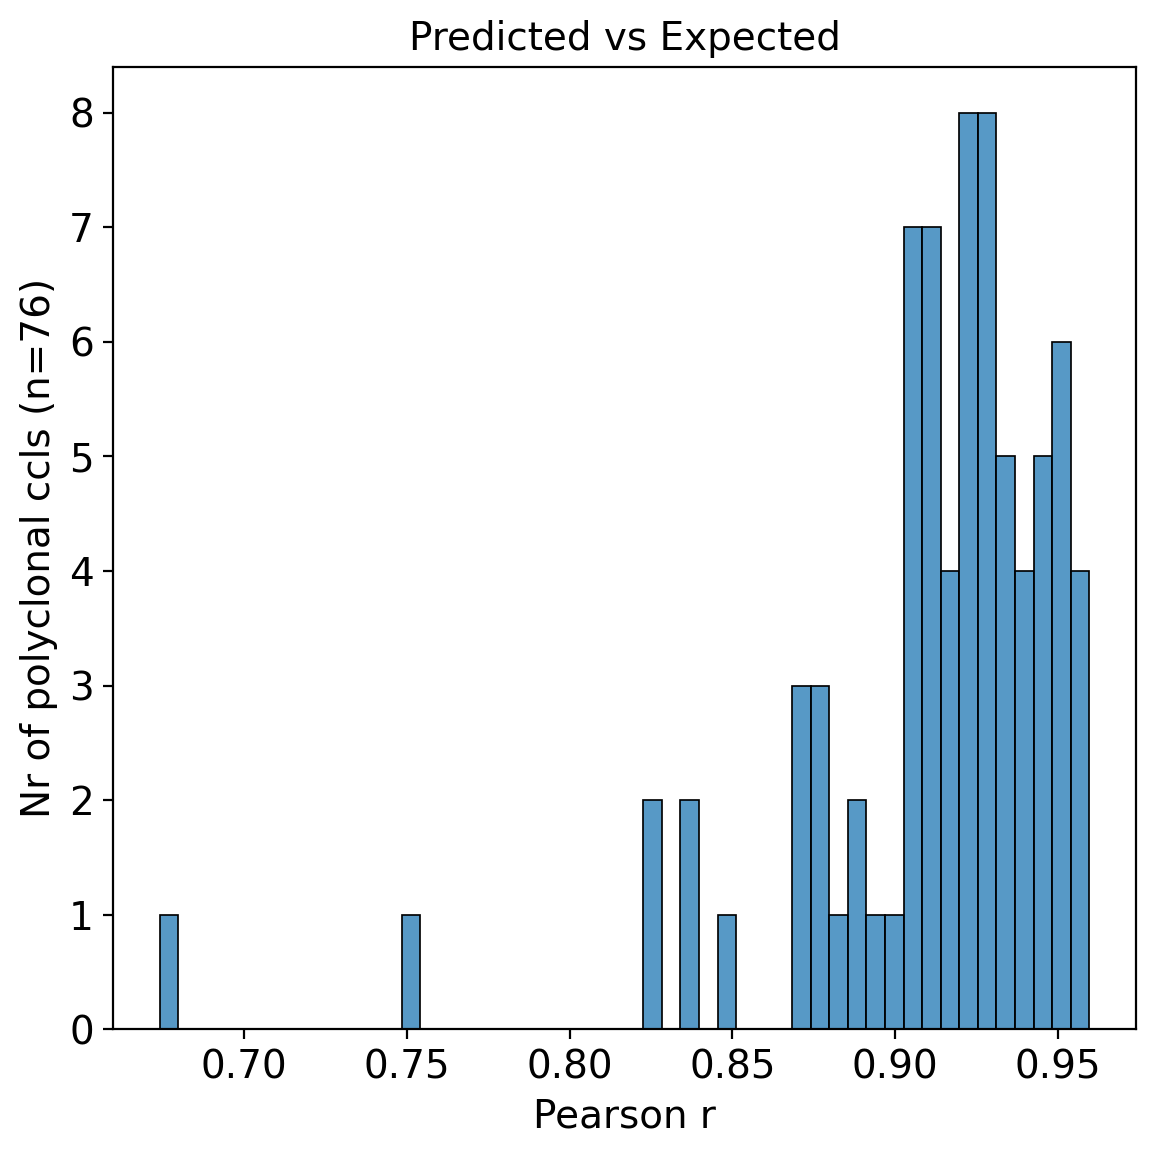

In [150]:
plt.figure(figsize=(6, 6))
sns.histplot(correlation_df["Pearson_r"],bins=50)
plt.title("Predicted vs Expected")
plt.xlabel("Pearson r")
plt.ylabel("Nr of polyclonal ccls (n=76)")
plt.grid(False)
plt.tight_layout()
plt.show()

In [84]:
from scipy.stats import pearsonr
import pandas as pd

correlation_results = []

for k in training_sets_dict.keys():
    # Combine observed and predicted values and drop NaNs
    temp_df = pd.DataFrame({
        "exp": df_exp[k],
        "pred": df_pred[k]
    }).dropna()

    if len(temp_df) > 1:
        r, p = pearsonr(temp_df["exp"], temp_df["pred"])
        correlation_results.append({
            "Drug": k,
            "Pearson_r": r,
            "p_value": p,
            "n_samples": len(temp_df)
        })
    else:
        correlation_results.append({
            "Drug": k,
            "Pearson_r": None,
            "p_value": None,
            "n_samples": len(temp_df)
        })

# Convert to DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Display or save
print(correlation_df)


                  Drug  Pearson_r       p_value  n_samples
0           Elephantin   0.793761  3.113567e-15         65
1           GSK2606414   0.605943  1.700853e-08         72
2               MG-132   0.452378  5.867877e-05         73
3               UMI-77   0.540507  6.907753e-06         61
4         N25720-51-A1   0.526493  1.310536e-05         61
..                 ...        ...           ...        ...
267          Gefitinib   0.389932  6.493105e-04         73
268             AZ6102   0.339058  3.574224e-03         72
269        Savolitinib   0.617108  6.090516e-09         73
270  N-acetyl cysteine   0.454603  2.057903e-04         62
271        Vinblastine   0.756923  1.698683e-12         61

[272 rows x 4 columns]


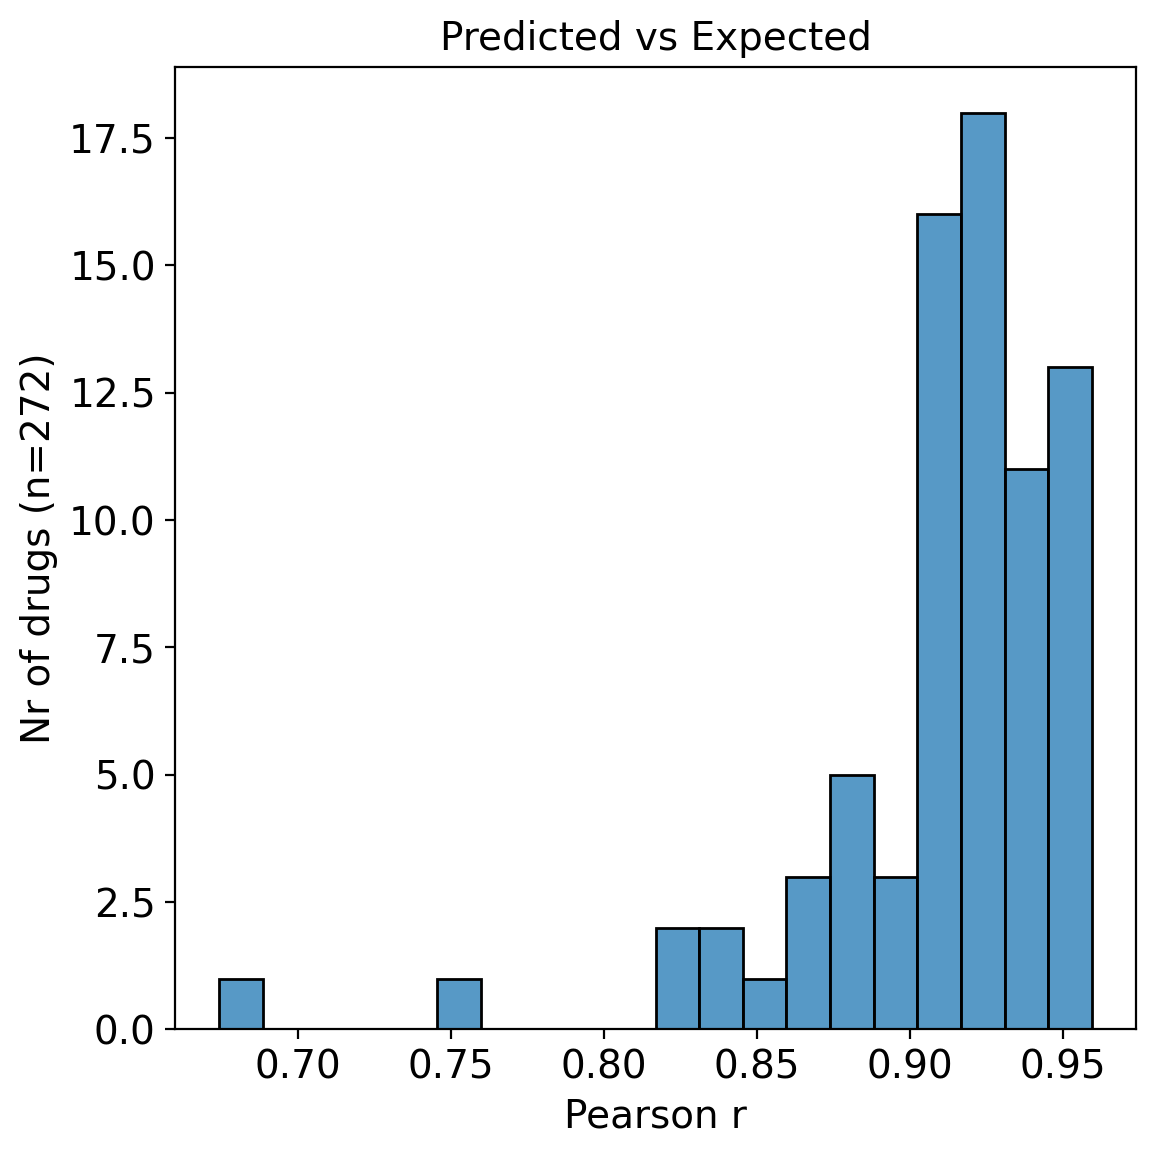

In [151]:
plt.figure(figsize=(6, 6))
sns.histplot(correlation_df["Pearson_r"])
plt.title("Predicted vs Expected")
plt.xlabel("Pearson r")
plt.ylabel("Nr of drugs (n=272)")
plt.grid(False)
plt.tight_layout()
plt.show()